# Content-Based Recommender System using Naive Bayes

This notebook implements two types of content-based recommendation systems using the MovieLens dataset:
1. User-specific recommender using Naive Bayes (user profile models)
2. Global recommender using Kronecker product of user/item features
3. Evaluation methodology for realistic recommendation performance

### Load and Preprocess Data

In [59]:
import pandas as pd
import os
import re

DATA_PATH = "../ml-latest-small"

ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

## 🧹 Preprocess Movie Metadata
tags_agg = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(tags_agg, on="movieId", how="left")
movies["tag"] = movies["tag"].fillna("")
movies["content"] = movies["genres"].str.replace("|", " ") + " " + movies["tag"]

In [60]:
movies.head()

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,Comedy Romance moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake


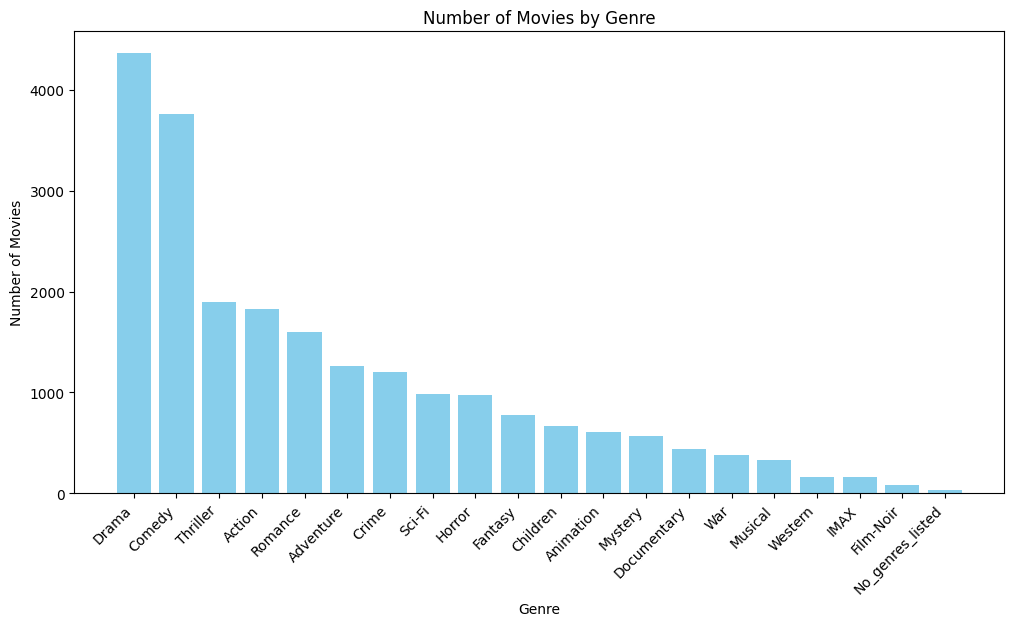

In [61]:
import matplotlib.pyplot as plt
from collections import Counter

movies_with_genres = movies.copy()
movies_with_genres['genres'] = movies_with_genres['genres'].str.split('|')

# Just for sake of visualization, we replace the class name
movies['genres'] = movies['genres'].replace('(no genres listed)', 'No_genres_listed')

# Creating a list with all genres
all_genres = '|'.join(movies['genres']).split('|')

# Counting all the genres
genre_counts = Counter(all_genres)

# Creating a DataFrame based on the counter
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

In [62]:
print(f"Number of unique tags: {len(tags['tag'].unique())}")

no_tags_count = len(movies[movies["tag"] == ""])
print(f"Number of films without tags: {no_tags_count}")

with_tags_count = len(movies[movies["tag"] != ""])
print(f"Number of films with tags: {with_tags_count}")

Number of unique tags: 1589
Number of films without tags: 8170
Number of films with tags: 1572


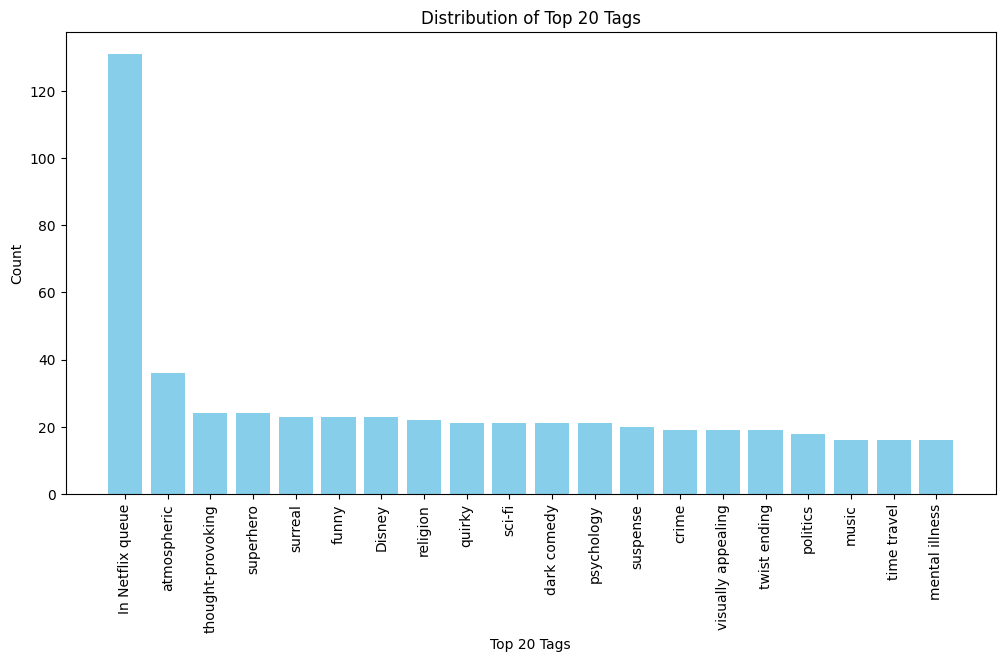

In [63]:
tags_count = tags["tag"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(tags_count.index[:20], tags_count.values[:20], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Top 20 Tags")
plt.ylabel("Count")
plt.title("Distribution of Top 20 Tags")
plt.show()

## 1. User-Specific Naive Bayes Recommender

The model is trained on metadata including the movie title and genres, with titles cleaned to remove release years.

In [64]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

In [65]:
# metadata available for each movie
metadata = movies[["movieId", "title", "genres"]]
metadata.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Removing the year from movie titles helps clean the data for content-based recommendation. The year adds no semantic value for models using text features like TF-IDF and can introduce noise or inflate the vocabulary. By focusing on the actual title, we ensure better feature extraction and more accurate similarity comparisons between movies.

In [66]:
metadata['title'] = metadata['title'].apply(clean_title)

/tmp/ipykernel_19613/4062237776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['title'] = metadata['title'].apply(clean_title)


In [67]:
metadata.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


### Binarize the genres

Binarizing genres turns categorical data into a binary format, making it easier for machine learning models to process. This method helps handle movies with multiple genres and captures interactions between them, improving recommendation accuracy. It simplifies the feature engineering process and ensures the model can effectively learn from genre information.

In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'].str.split('|'))

In [69]:
genres_encoded

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(9742, 20))

In [70]:
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
genres_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)
# metadata = metadata.drop(columns=['(no genres listed)'])
metadata.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def user_specific_model(user_id, top_k=10):
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, metadata, on='movieId')
    

    # Create labels
    user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    user_data = user_data.dropna(subset=['label'])
    user_data['label'] = user_data['label'].astype(int)

    if user_data.empty:
        return pd.DataFrame()
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])

    X_train = user_data.drop(columns=['userId', 'rating', 'label', 'timestamp'])  # drop irrelevant columns
    y_train = user_data['label']

    print(X_train.head())

    pipeline.fit(X_train, y_train)

    seen = user_ratings['movieId'].unique()
    candidate_pool = metadata[~metadata['movieId'].isin(seen)].copy()
    input_cols = list(X_train.columns)  # X used during training

    candidate_pool['score'] = pipeline.predict_proba(candidate_pool[input_cols])[:, 1]
    return candidate_pool.sort_values("score", ascending=False)[['movieId', 'title', 'score']].head(top_k)

In [74]:
user_specific_model(user_id=37)

   movieId                            title  Action  Adventure  Animation  \
0      150                        Apollo 13       0          1          0   
2      165       Die Hard: With a Vengeance       1          0          0   
3      231  Dumb & Dumber (Dumb and Dumber)       0          1          0   
4      292                         Outbreak       1          0          0   
5      296                     Pulp Fiction       0          0          0   

   Children  Comedy  Crime  Documentary  Drama  ...  Horror  IMAX  Musical  \
0         0       0      0            0      1  ...       0     1        0   
2         0       0      1            0      0  ...       0     0        0   
3         0       1      0            0      0  ...       0     0        0   
4         0       0      0            0      1  ...       0     0        0   
5         0       1      1            0      1  ...       0     0        0   

   Mystery  No_genres_listed  Romance  Sci-Fi  Thriller  War  Wester

,movieId,title,score
5657,27549,Dead or Alive: Final,0.999369
454,519,RoboCop 3,0.999117
2248,2985,RoboCop,0.999117
4843,7235,Ichi the Killer (Koroshiya 1),0.999023
3989,5628,Wasabi,0.998991
19,20,Money Train,0.998991
3657,5027,Another 48 Hrs.,0.998991
4693,7007,"Last Boy Scout, The",0.998991
118,145,Bad Boys,0.998991
1076,1396,Sneakers,0.998991


## 2. Global Content-Based Recommender (Single Model for All Users)

In [ ]:
# Create a new column 'content' that combines the title, tag, and genres
movies['content'] = movies['title'].apply(clean_title) + " " + movies['tag'] + " " + movies['genres'].str.replace("|", " ")
movies

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Toy Story pixar pixar fun Adventure Animation ...
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,Jumanji fantasy magic board game Robin William...
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,Grumpier Old Men moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Waiting to Exhale Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Father of the Bride Part II pregnancy remake C...
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,,Black Butler: Book of the Atlantic Action Ani...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,,No Game No Life: Zero Animation Comedy Fantasy
9739,193585,Flint (2017),Drama,,Flint Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,,Bungo Stray Dogs: Dead Apple Action Animation


In [ ]:
def train_global_model():
    data = pd.merge(ratings, movies, on='movieId')

    data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    X = tfidf.fit_transform(data['content'])
    y = data['label']

    model = MultinomialNB()
    model.fit(X, y)
    return model, tfidf

model_global, tfidf_global = train_global_model()

def recommend_global(user_id, top_k=10):
    seen = ratings[ratings['userId'] == user_id]['movieId'].unique()
    unseen = tags_agg[~tags_agg['movieId'].isin(seen)].copy()
    X_test = tfidf_global.transform(unseen['tag'])

    unseen['score'] = model_global.predict_proba(X_test)[:, 1]
    result = unseen.merge(movies[['movieId', 'title']], on='movieId')
    return result.sort_values('score', ascending=False)[['movieId', 'title', 'score']].head(top_k)

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                               Comedy|Romance   
2                        Action|Crime|Thriller   
3                             Mystery|Thriller   
4                       Crime|Mystery|Thriller   

                                                 tag  \
0                                    pixar pixar fun   
1                                          moldy old   
2                                                      
3                 mystery twist ending serial killer  

### 🔍 Test it:

In [77]:
recommend_global(user_id=1)

,movieId,title,score
1035,7361,Eternal Sunshine of the Spotless Mind (2004),0.998303
71,318,"Shawshank Redemption, The (1994)",0.997536
66,293,Léon: The Professional (a.k.a. The Professiona...,0.995593
1326,79132,Inception (2010),0.994694
750,4878,Donnie Darko (2001),0.994536
128,628,Primal Fear (1996),0.992864
377,1921,Pi (1998),0.990409
1324,74458,Shutter Island (2010),0.989519
1361,99114,Django Unchained (2012),0.988773
156,903,Vertigo (1958),0.988277
